In [1]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [2]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)
seg.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
from fastai.vision.data import _df_to_fns_labels

In [4]:
fnames, labels = _df_to_fns_labels(seg, label_delim=' ')

In [5]:
labels

array([list(['16', '0']), list(['7', '1', '2', '0']), list(['5']), list(['1']), ..., list(['5']), list(['7']),
       list(['25', '2', '21']), list(['2', '0'])], dtype=object)

In [6]:
classes = uniqueify(np.concatenate(labels)); classes

['16',
 '0',
 '7',
 '1',
 '2',
 '5',
 '18',
 '25',
 '23',
 '21',
 '24',
 '6',
 '11',
 '3',
 '12',
 '13',
 '14',
 '4',
 '20',
 '22',
 '17',
 '19',
 '8',
 '9',
 '10',
 '26',
 '27',
 '15']

In [7]:
norm,denorm = normalize_funcs(*imagenet_stats)

In [8]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.3)

In [9]:
def get_data(size, bs):
    if size==64: 
        return ImageDataBunch.from_df(path=PATH, folder=TRAIN64, df=pd.read_csv(PATH/MASKS), sep=' ', suffix='.png',
                               bs = bs)
    if size==128: 
        return ImageDataBunch.from_df(path=PATH, folder=TRAIN128, df=pd.read_csv(PATH/MASKS), sep=' ', suffix='.png',
                                bs=bs)
    if size==256: 
        return ImageDataBunch.from_df(path=PATH, folder=TRAIN256, df=pd.read_csv(PATH/MASKS), sep=' ', suffix='.png', 
                                 test=TEST256, bs = bs)


In [10]:
def f1(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>0.5).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

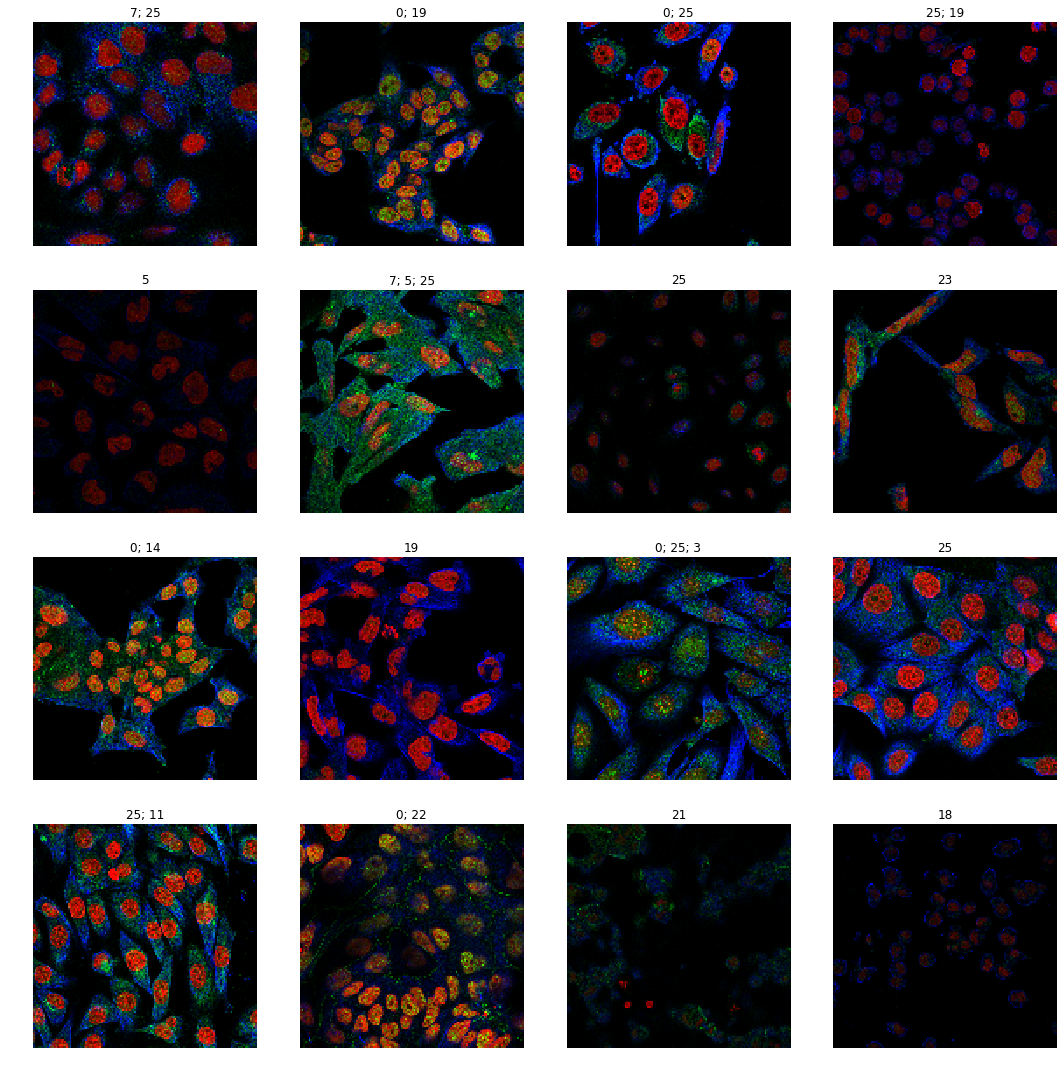

In [13]:
data = get_data(128, 256) 
data.show_batch(rows=4, figsize=(15,15))

In [14]:
from fastai.vision.models.darknet import *
darknet = Darknet([1,2,4,4], 28)
darknet53 = Darknet([1,2,8,8,4], 28)

In [15]:
learn = Learner(get_data(256,16), darknet53, metrics=[accuracy_thresh, f1])
# learn = Learner(data256, model, metrics=[accuracy_thresh, f1])

In [20]:
learn.callbacks

[]

In [29]:
learn.to_fp16();

In [18]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

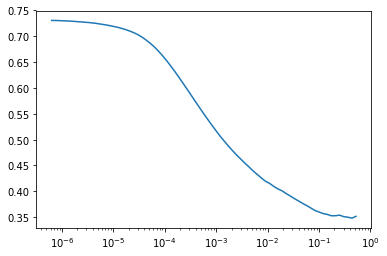

In [12]:
learn.recorder.plot()

In [37]:
lr=3e-3

In [27]:
learn.fit_one_cycle(10, lr)

Total time: 32:24
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.162796    nan         0.936593         0.225200  (03:13)
2      0.156896    0.164667    0.942729         0.300463  (03:14)
3      0.147190    0.180653    0.941311         0.217346  (03:14)
4      0.138508    0.140672    0.951155         0.359710  (03:14)
5      0.131994    0.146109    0.950324         0.409937  (03:14)
6      0.124860    0.145714    0.950774         0.412475  (03:14)
7      0.118855    0.125142    0.956010         0.475002  (03:14)
8      0.112971    0.126797    0.955416         0.424527  (03:14)
9      0.107479    0.112256    0.960318         0.526077  (03:15)
10     0.104958    0.110989    0.960762         0.532406  (03:14)



In [30]:
learn.load('darknet53_128')

In [32]:
learn.loss_func = FocalLoss()

In [35]:
learn.fit_one_cycle(10, lr/2)

Total time: 32:41
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.899437    0.847397    0.960923         0.525132  (03:13)
2      0.854920    0.909026    0.957995         0.497112  (03:14)
3      0.858052    0.932014    0.956233         0.478630  (03:14)
4      0.844973    0.869138    0.959897         0.519150  (03:22)
5      0.813348    0.897767    0.958250         0.507709  (03:20)
6      0.780716    0.864511    0.960882         0.547320  (03:15)
7      0.731245    0.872085    0.959659         0.528864  (03:15)
8      0.696817    0.797449    0.963219         0.576548  (03:15)
9      0.649565    0.790508    0.963926         0.604682  (03:15)
10     0.626433    0.789872    0.963938         0.603451  (03:15)



In [36]:
learn.save('darknet53_128_FL')

In [44]:
learn = Learner(get_data(256, 16), darknet53, metrics=[accuracy_thresh, f1])
learn.to_fp16();
learn.loss_func = FocalLoss()

In [45]:
learn.load('darknet53_128_FL')

In [36]:
learn.fit_one_cycle(10, lr/4)

Total time: 1:45:23
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.822558    0.806431    0.962259         0.543379  (10:32)
2      0.843433    0.819640    0.962110         0.546423  (10:33)
3      0.837557    1.006118    0.956781         0.538963  (10:33)
4      0.833782    nan         0.961343         0.568338  (10:33)
5      0.762198    0.832358    0.962168         0.558108  (10:32)
6      0.725964    0.759025    0.965402         0.619627  (10:31)
7      0.800497    0.713498    0.966787         0.620725  (10:31)
8      0.656759    0.684351    0.968184         0.661665  (10:32)
9      0.612296    0.672192    0.969037         0.668452  (10:32)
10     0.620023    0.683057    0.968894         0.672120  (10:31)



In [38]:
learn.save('darknet53_256_FL')

In [46]:
learn.fit_one_cycle(10, lr/8)

AttributeError: 'DataFrame' object has no attribute '__name__'

In [1]:
learn.data.valid_dl.add_tfm(to_half)

NameError: name 'learn' is not defined

In [40]:
p_v, t_v = learn.get_preds()

In [68]:
p_v[71].sigmoid()>0.4, t_v[71]

(tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0], dtype=torch.uint8),
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [51]:
accuracy_thresh(p_v,t_v, sigmoid=True),f1(p_v,t_v, sigmoid=True)

(tensor(0.9689), tensor(0.6721))

In [49]:
th_lafoss = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

In [47]:
p_np, t_np = to_np(p_v), to_np(t_v)

In [58]:
p_np[0], t_np[0], p_v[0].sigmoid()>0.2

(array([-3.101562, -0.051025, -2.132812,  3.220703, -0.85791 , -2.181641, -3.416016, -1.786133, -1.098633, -2.404297,
        -3.796875, -2.521484, -2.246094, -1.692383, -3.257812, -3.382812, -3.166016, -1.586914, -3.960938, -3.396484,
        -3.964844, -2.470703, -3.314453, -6.726562, -7.050781, -3.642578, -6.21875 , -5.53125 ], dtype=float32),
 array([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0], dtype=torch.uint8))

In [208]:
def f1_np(thresh) -> float:
    y_pred=p_np 
    y_true=t_np
    eps=1e-7
    beta2=1
    
    y_pred = (y_pred>thresh)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+eps)
    rec = TP/(y_true.sum(1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return -res.mean()

In [253]:
from scipy.optimize import basinhopping

In [303]:
x0 = 0.4*np.ones(28); f1_np(x0)

-0.6526594263774549

In [304]:
res = basinhopping(f1_np, x0, niter=100, stepsize=1e-1)

In [305]:
res['x'], res['fun']

(array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4]), -0.6526594263774549)

In [46]:
t_v.sum(0).int()

tensor([  92, 2577,  519,  214,  692,  507,  171, 1649,  576,  723,   69,  195,
         222,  313,  129,  118,  208,  376,   38,  159,   43,  302,    8,    4,
           3,   72,    1,    1], dtype=torch.int32)

In [121]:
out.dtype

torch.float32

# Generate sub file 

In [21]:
learn.to_fp16();

In [22]:
learn.load('darknet53_256_FL')

In [23]:
learn.data.test_dl.add_tfm(to_half)

In [24]:
p,t = learn.get_preds(is_test=True)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1126: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [31]:
p[0]>0.4

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)

In [25]:
t.shape, p.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [26]:
dir = get_image_files(TEST256)
dir = [f.name[:-4] for f in dir]

In [27]:
dir[0:5]

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
 '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']

In [28]:
test_names[0:5]

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
 '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
 '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']

In [29]:
preds = p
threshold = 0.4
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

torch.Size([11702, 28])


In [32]:
filenames = np.array(test_names)
dir_names = np.array(dir)

In [33]:
frame = pd.DataFrame(np.array([dir_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('my_submission.csv', index=False)

In [34]:
#fix indexing
f1 = pd.read_csv('sample_submission.csv')
f1.drop('Predicted', axis=1, inplace=True)
f2 = pd.read_csv('my_submission.csv')
f1 = f1.merge(f2, left_on='Id', right_on='Id', how='outer')
f1.to_csv('my_new_submission.csv', index=False)

In [35]:
f1.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25
